<a href="https://colab.research.google.com/github/tanmayyb/screw-detector/blob/main/yolov5s.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data Loading and Basic Functions

In [5]:
import os
import requests
import random
import json
import numpy as np
from skimage import io
from scipy import ndimage
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

import torch
from torch import nn
import torch.optim as optim
from torchsummary import summary
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [6]:
# @title Choose device
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [7]:
device = set_device()

GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


In [8]:
import warnings
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

In [9]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [10]:
cd 'gdrive/My Drive/screw_dataset/unpacked/'

/content/gdrive/My Drive/screw_dataset/unpacked


In [11]:
#Load the json file with the annotation metadata
with open('mvtec_screws.json') as f:
  data = json.load(f)

print(data.keys())
print(data['images'][0])
print(data['annotations'][0])

dict_keys(['categories', 'images', 'annotations', 'licenses', 'info'])
{'file_name': 'screws_001.png', 'height': 1440, 'width': 1920, 'id': 1, 'license': 1}
{'area': 3440.97, 'bbox': [184.5, 876.313, 55, 62.5631, 0], 'category_id': 7, 'id': 1001, 'image_id': 1, 'is_crowd': 0}


In [12]:
#Make a dictionary (imgdict), and attach image metadata by image ID
imgdict  = {l['id']:l for l in data['images']}

In [13]:
#attach images to imgdict that contains metadata
for i in imgdict.values():
  i['image'] = io.imread(os.path.join('images', i['file_name']))[:,:,:3]

In [14]:
#@title set up `annodict` annotation dict

# remap annotations to dict by image_id
from collections import defaultdict
annodict = defaultdict(list)
for annotation in data['annotations']:
  annodict[annotation['image_id']].append(annotation)

# setup list of categories
categories = data['categories']
ncategories = len(categories)
cat_ids = [i['id'] for i in categories]

In [15]:
category_names = {7:'nut', 3:'wood screw', 2:'lag wood screw', 8:'bolt',
                  6:'black oxide screw', 5:'shiny screw', 4:'short wood screw',
                  1:'long lag screw', 9:'large nut', 11:'nut', 10:'nut',
                  12:'machine screw', 13:'short machine screw' }

In [16]:
from matplotlib import pyplot as plt
from matplotlib import rcParams, gridspec
from matplotlib import patches, transforms as plt_transforms

rcParams['figure.figsize'] = [16, 6]
rcParams['font.size'] =14
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [17]:
#@title subimage extractor functions 
def unpack_bbox(bbox):
  #bbox as in the json/COCO data format (centerx, centery, width, height, theta is in radians)

  rot_center = np.array((bbox[1], bbox[0])).T
  width = bbox[3]
  height = bbox[2]
  theta = -bbox[4]+np.pi/2 #radians
  return rot_center, width, height, theta

def extract_subimg_bbox(im, bbox):
  return extract_subimg(im, *unpack_bbox(bbox))

def extract_subimg(im, rot_center, width, height, theta):
  #rotates box
  rot_bbox = rotbbox_from_coords(rot_center, width, height, theta)

  subimg = im[rot_bbox[0,1]:rot_bbox[1,1],rot_bbox[0,0]:rot_bbox[1,0]]
  rotated_im = ndimage.rotate(subimg, np.degrees(theta)+180)
  newcenter = (np.array(rotated_im.shape)/2).astype(np.int)
  rotated_im = rotated_im[int(newcenter[0]-height/2):int(newcenter[0]+height/2), int(newcenter[1]-width/2):int(newcenter[1]+width/2), :3]  #drop alpha channel, if it's there

  return rotated_im


def rotcorners_from_coords(rot_center, width, height, theta):
  rotation = np.array(( (np.cos(theta), -np.sin(theta)),
               (np.sin(theta),  np.cos(theta))))

  wvec = np.dot(rotation, (width/2, 0))
  hvec = np.dot(rotation, (0, height/2))
  
  #obtains corner points after rotation
  corner_points = rot_center + [wvec+hvec, wvec-hvec, -wvec+hvec, -wvec-hvec]
  #                            [tr, br, tl, bl]
  
  return corner_points

def rotbbox_from_coords(rot_center, width, height, theta):
  corner_points = rotcorners_from_coords(rot_center, width, height, theta)
  rot_bbox = np.array((corner_points.min(0), corner_points.max(0))).astype(np.int)
  #constrain inside image
  rot_bbox[rot_bbox < 0] = 0

  return rot_bbox






In [18]:
# create a dict mapping category id to all subimages, can take some time to run
# this dictionary contains categorised sub images
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  fxn()
  cat_imgdict = defaultdict(list)
  for img_id, image in imgdict.items():
    for annotation in annodict[img_id]:
      bbox = annotation['bbox']
      subimg = extract_subimg_bbox(image['image'], bbox)
      cat_imgdict[annotation['category_id']].append(subimg.copy())

## Get Patches

In [19]:
#@title get nut patches
use_categories = [7, 10]

patch_size = np.array((128,128))
num_patches_per_category = 500

nut_patches = []
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  fxn()
  for img_id, image in imgdict.items():
    for annotation in annodict[img_id]:
      
      if annotation['category_id'] in use_categories:
        bbox = annotation['bbox']
        rot_center, width, height, theta = unpack_bbox(bbox)
        subimg = extract_subimg(image['image'], rot_center, patch_size[0], patch_size[1], 0)
        
        if all(subimg.shape[:2] == patch_size):
          nut_patches.append(subimg)
          #plt.figure()
          #plt.imshow(subimg)

    if len(nut_patches) >= num_patches_per_category:
      break

In [20]:
#@title get random blank patches
#Select random blank patches
blank_patches = []
for i in range(len(nut_patches)):
  while True: #until a suitable random patch is found
    #choose random image
    imgid, imgobj = random.choice(list(imgdict.items()))
    im = imgobj['image']
    #choose random place at least half a patch size from edges
    rand_center = np.random.randint((patch_size//2), np.array(im.shape)[:2] - patch_size//2)
    corners = rotcorners_from_coords(rand_center, patch_size[0], patch_size[1], 0)
    #check if the random patch intersects with any labeled objects
    if not any([Polygon(corners).intersects(Polygon(rotcorners_from_coords(*unpack_bbox(annotation['bbox'])))) for annotation in annodict[imgid]]):
      rand_patch = im[rand_center[0]-patch_size[0]//2:rand_center[0]+patch_size[0]//2, rand_center[1]-patch_size[1]//2:rand_center[1]+patch_size[1]//2]
      blank_patches.append(rand_patch)
      break

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


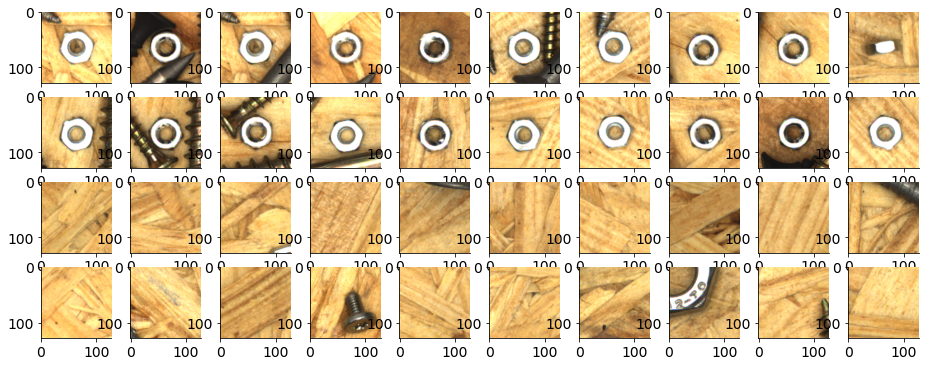

In [21]:
#@title visualize nut and blank patches
plt.figure()
num_examples = 10
gs = gridspec.GridSpec(4, num_examples, wspace=.05)
for j in range(2):
  for i in range(num_examples):
    plt.subplot(gs[j, i])
    plt.imshow(nut_patches[i+j*10])
for j in range(2):
  for i in range(num_examples):
    plt.subplot(gs[j+2, i])
    plt.imshow(blank_patches[i+j*10])

In [22]:
patch_labels = [1,]*len(nut_patches) + [0,]*len(blank_patches)  #1 if nut
all_patches = nut_patches + blank_patches #list concat

# randomly shuffle
shuffle_idx = np.random.choice(len(patch_labels), len(patch_labels), replace=False)
patch_labels = [patch_labels[i] for i in shuffle_idx]
all_patches = [all_patches[i] for i in shuffle_idx]

# Check shapes are correct
# assert all([p.shape == (128,128,3) for p in all_patches])
[i for i,p in enumerate(all_patches) if p.shape != (128, 128, 3)]

[]

## Preprocessing Data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


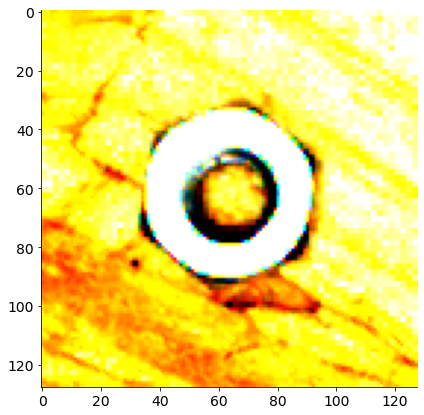

In [23]:
# Preprocess data
preprocess = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_frac = .2
train_number = int(len(all_patches)*train_frac)
# test_nuumber = all_patches.len()-train_number
train_patches, train_labels = all_patches[:train_number], patch_labels[:train_number]
test_patches, test_labels = all_patches[train_number:], patch_labels[train_number:]

plt.figure()
plt.imshow(preprocess(all_patches[0]).permute(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


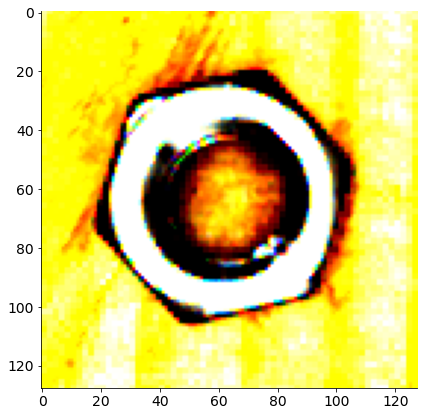

In [24]:
plt.imshow(preprocess(all_patches[100]).permute(1, 2, 0))

## Training Model

In [25]:
# Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 2022-7-25 Python-3.7.13 torch-1.12.0+cu113 CPU



  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


In [26]:
# Images
imgs = ['https://ultralytics.com/images/zidane.jpg']  # batch of images

In [27]:
# Inference
results = model(imgs)

# Results
results.print()
results.save()  # or .show()

results.xyxy[0]  # img1 predictions (tensor)

Saved 1 image to runs/detect/exp


image 1/1: 720x1280 2 persons, 2 ties
Speed: 248.2ms pre-process, 521.1ms inference, 22.3ms NMS per image at shape (1, 3, 384, 640)


tensor([[7.42975e+02, 4.83957e+01, 1.14184e+03, 7.20000e+02, 8.81052e-01, 0.00000e+00],
        [4.42008e+02, 4.37522e+02, 4.96654e+02, 7.09974e+02, 6.75214e-01, 2.70000e+01],
        [1.23024e+02, 1.93287e+02, 7.15662e+02, 7.19724e+02, 6.65813e-01, 0.00000e+00],
        [9.82803e+02, 3.08417e+02, 1.02737e+03, 4.19987e+02, 2.60076e-01, 2.70000e+01]])